# Homework 11

Author: Mao Nishino

In [111]:
# Import relevant libraries
import zipfile
import io
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Open the zip file and create a list of images
def load_zip_image(filename: str):
    """ Load an pgm image and create list of images

    Args:
        filename: str
            The name of the files.

    Returns:
        images: list
            list of pgm images in the file.
    """

    # Open the zip file and create a list of images
    zip = zipfile.ZipFile(filename, 'r')
    images = []
    for image_name in zip.namelist():
        image_bytes = io.BytesIO(zip.read(image_name))
        if image_bytes.readline() == b'P5\n' or image_bytes.readline() == b'19 19\r\n':
            images.append(Image.open(image_bytes))
    return images

def images_to_array(images: list):
    """ Convert a list of PIL images to a numpy array

    Args:
        images: list
            A list of PIL images.

    Returns:
        array_images: np.ndarray of shape (# images, # pixels)
            array of flattened images. 
            Each row is an image and each column represents a pixel.
    """

    array_images = np.array(images[0]).flatten().reshape(1, -1)
    for image in images[1:]:
        array_image = np.array(image).flatten().reshape(1, -1)
        array_images = np.concatenate([array_images, array_image])
    return array_images
    
face_images = load_zip_image('./faces.zip')
bg_images = load_zip_image('./background.zip')

face_array = images_to_array(face_images)
bg_array = images_to_array(bg_images)

## Problem (a)
Perform Principal Component Analysis on the face images. Discard the two
largest eigenvalue and plot the graph of the remaining eigenvalues sorted in decreasing order.

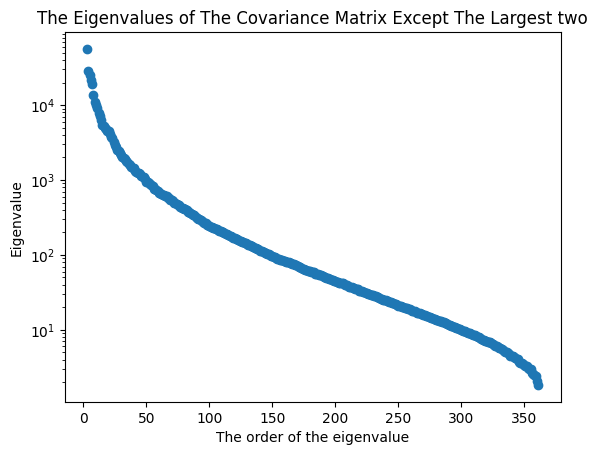

In [112]:
# Do PCA
pca = PCA()
pca.fit(face_array)

# Sort eigenvalues and plot them except the first two
num_evals = len(pca.explained_variance_)
sorted_evals = np.sort(pca.explained_variance_)[::-1]

plt.figure()
plt.xlabel('The order of the eigenvalue')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.scatter(range(3,num_evals+1), sorted_evals[2:])
plt.title('The Eigenvalues of The Covariance Matrix Except The Largest two')
plt.show()

## Problem (b)
Plot a graph of the coordinates of the faces projected to the 2D plane generated
by the first and second principal component. 

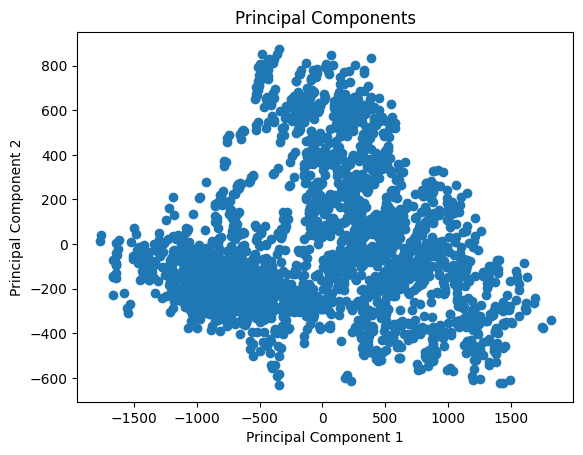

In [113]:
pcs = pca.transform(face_array)

plt.figure()
plt.title('Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.scatter(pcs[:,0], pcs[:, 1])
plt.show()

# Problem (c)
On the same graph, display the coordinates of the projections from b) using one
color (red or light gray) and the projections of the background patches on the
same two principal components (PCs) using another color (e.g. black). Be sure
to subtract the mean of the faces and project to the PCs of the faces. 

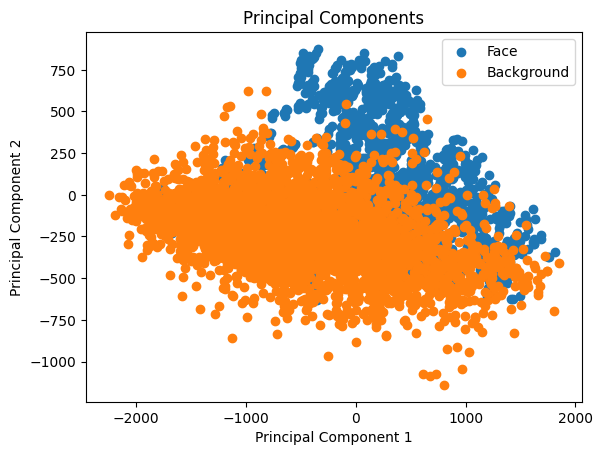

In [114]:
pcs_face = pca.transform(face_array)
pcs_bgs = pca.transform(bg_array)

plt.figure()
plt.title('Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.scatter(pcs_face[:, 0], pcs_face[:, 1], label = 'Face')
plt.scatter(pcs_bgs[:, 0], pcs_bgs[:, 1], label = 'Background')
plt.legend()
plt.show()

# Problem (d)
Using the model from a), display the image face_00067.pgm and its reconstruction using 20 PCs.

### Preliminaries
Let $x\in \mathbb{R}^d$ be a feature vector in the original space and $\{u_1,\cdots u_d\} \subset \mathbb{R}^d$ be principal component vectors. $u_i$ are eigenvectors of the covariance matrix of the training set, and they form an orthonormal basis (because covariance matrices are symmetric, and symmetric matrices have orthonormal eigenvectors). 

The principal components $c_1\cdots c_d$ of $x$, principal component vectors $u$ and $x$ has the following relation:
$\begin{equation}x = \bar{x} + c_1 u_1 + \cdots +c_{d} u_d \tag*{} \end{equation}$
where $\bar{x}$ is the mean of the training data. (PCA finds the orthonormal basis that can approximate the data even if we take only some of basis on the right hand side.)

We are asked to cut off the sum on the right hand side and use only the first 20 term. That is, we have to approximate the feature vector $x$ corresponding to `face_000067.pgm` by
$\begin{equation}x \sim \bar{x} + c_1 u_1 + \cdots +c_{20} u_{20} \tag*{} \end{equation}$
The right hand side is equivalent to
$\begin{equation}x = \bar{x} + U_{20} c_{20} \tag*{} \end{equation}$
where $c_{20}=(c_1,\cdots ,c_{20})^T, U_{20} = (u_1,\cdots u_{20})$.

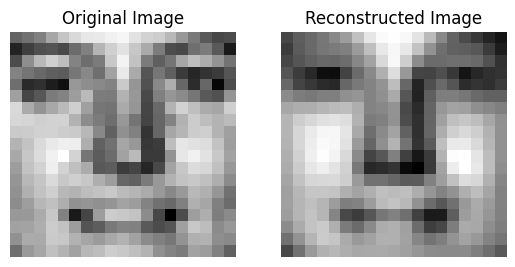

In [115]:
#pcs_20 is equivalent to the transpose of U_20 above
#pcs_face[66, :20] is equivalent to c_20 above
pcs_20 = pca.components_[:20]
reconstructed_image_67 = (pca.mean_+ pcs_20.T @ pcs_face[66, :20]).reshape(19, 19)

fig, ax = plt.subplots(1, 2)
ax[0].axis('off')
ax[0].imshow(face_images[66], cmap = 'gray')
ax[0].title.set_text('Original Image')
ax[1].axis('off')
ax[1].imshow(reconstructed_image_67, cmap = 'gray')
ax[1].title.set_text('Reconstructed Image')
fig.show()

# Problem (e)

Using the model from a), display the image B1_00192.pgm and its reconstruction using 20 PCs.

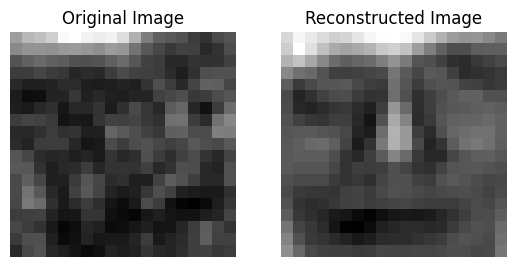

In [116]:
reconstructed_image_191 = (pcs_20.T @ pcs_bgs[191, :20] + pca.mean_).reshape(19, 19)

fig, ax = plt.subplots(1, 2)
ax[0].axis('off')
ax[0].imshow(bg_images[191], cmap = 'gray')
ax[0].title.set_text('Original Image')
ax[1].axis('off')
ax[1].imshow(reconstructed_image_191, cmap = 'gray')
ax[1].title.set_text('Reconstructed Image')
fig.show()

# Problem (f) 
Compute the distances of the faces and the background points to the plane generated by the 20 largest PCs. On the same graph, plot the computed distances (on
the y-axis) vs the coordinates of the projections on the second PC (on the x-axis)
for the faces and background patches using two different colors. (2 points)


### Preliminaries
(We use some notations from Problem (d).)
For each face or background vector $x\in \mathbb{R}^d$, What we want to find is $\min_{p\in P}\|x-p\|$ where $P = \{\bar{x} + c_1u_1+\cdots +c_{20} u_{20}|c_i\in \mathbb{R}, u_i:\textrm{first 20 PCs}\}$. We note that $\hat{p}\in P$ that achieves the minimum can be found by $\hat{p} = \bar{x} + c_1u_1+\cdots c_{20} u_{20}$ where $c_i$ is the principal component of $x$ corresponding to the principal component vector $u_i$ (or basically $c_i = (x-\bar{x})\cdot u_i$.)
We can now find $\min_{p\in P}\|x-p\|$ by $\|x-\hat{p}\|$.

Equivalently, we can use the fact that principal component vectors $u_1\cdots u_{d}$ forms an orthonormal basis. We write
$x-\bar{x} = c_1u_1+\cdots c_{d} u_{d}$ where (again) $c_i = (x-\bar{x})\cdot u_i$. Then, for the $\hat{p}$ above, we have 
$\begin{equation}\|x-\hat{p}\| = \|c_{21}u_{21}+\cdots +c_{d}u_{d}\| = \sqrt{c_{21}^2 +\cdots +c_{d}^2} \tag*{} \end{equation}$
where the last equation is using the fact that $\|x\| = \sqrt{x\cdot x}$ and that $u_i$ are orthonormal.

We use the second method to calculate the distance.

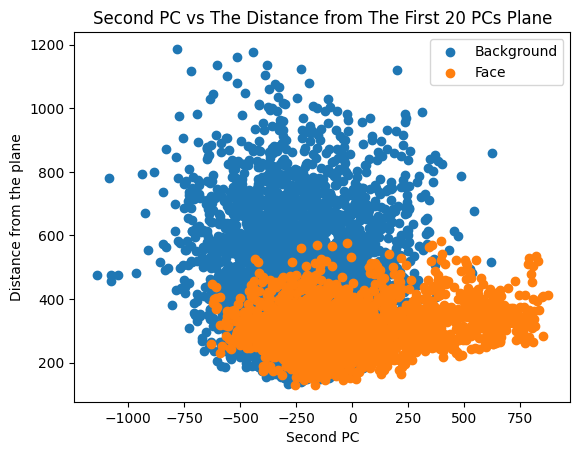

In [117]:
# These calculations are redundant, but they are here for self-containment
pcs_face = pca.transform(face_array)
pcs_bgs = pca.transform(bg_array)

# Take last PCs and take its norm
dist_face = np.linalg.norm(pcs_face[:, 20:], axis = 1)
dist_bgs = np.linalg.norm(pcs_bgs[:, 20:], axis = 1)

# Plot them
plt.figure()
plt.title('Second PC vs The Distance from The First 20 PCs Plane')
plt.xlabel('Second PC')
plt.ylabel('Distance from the plane')
plt.scatter(pcs_bgs[:,1], dist_bgs, label = 'Background')
plt.scatter(pcs_face[:,1], dist_face, label = 'Face')
plt.legend()
plt.show()

## Problem (g)

 On the same graph, plot the histogram of the distances obtained at f) for the faces
in one color and for the background patches in another color. (2 points)

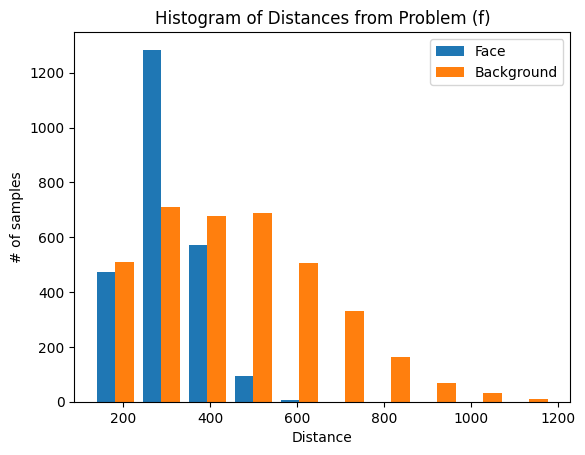

In [118]:
plt.figure()
plt.title('Histogram of Distances from Problem (f)')
plt.xlabel('Distance')
plt.ylabel('# of samples')
plt.hist([dist_face, dist_bgs], label = ['Face', 'Background'])
plt.legend()
plt.show()